# Embedding
It is a way to turn words into meaningful numbers. <br /> It stores how a word is used. It can capture things like which words appear near it, what it can replace, and what usually comes before or after it.

cat is close to dog pet and animal. <br />
food is close to drink, cook. <br /> <br />
These embeddings are learned automatically. <br /> <br />

`block_size` : How many tokens the model procress in one forward pass. <br />
In the example below we are taking 15 data in a chunk.


In [4]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [5]:
import string


data = string.printable

def get_chunk(block_size, idx):
    x = data[idx:idx + block_size]
    y = data[idx + 1:idx + block_size + 1]
    return x, y

x, y = get_chunk(12, 5)

### Input and expected output
We have the above function cause we want to predict the next token in our character level model. So the code below gives the example of what we might expect as output `y` when our input is `x`. <br />
<b>Character based model.</b>

In [6]:
from src.tokenizer import Tokenizer
import torch

tokenizer = Tokenizer(data)

phrase = torch.tensor(tokenizer.encode("full-stack application"))

block_size = 10

for i in range(0, block_size):
    input_arr = phrase[:i + 1]
    print(f"when the input is {input_arr} output is {phrase[i + 1]}")



when the input is tensor([15]) output is 30
when the input is tensor([15, 30]) output is 21
when the input is tensor([15, 30, 21]) output is 21
when the input is tensor([15, 30, 21, 21]) output is 74
when the input is tensor([15, 30, 21, 21, 74]) output is 28
when the input is tensor([15, 30, 21, 21, 74, 28]) output is 29
when the input is tensor([15, 30, 21, 21, 74, 28, 29]) output is 10
when the input is tensor([15, 30, 21, 21, 74, 28, 29, 10]) output is 12
when the input is tensor([15, 30, 21, 21, 74, 28, 29, 10, 12]) output is 20
when the input is tensor([15, 30, 21, 21, 74, 28, 29, 10, 12, 20]) output is 94


## Positional embedding
It is a method that transformers adds unique numerical vectors to input token to represent order and position in a sequence. <br />


For example
Hello world  <br />
Index :01234.... <br />
And we have the positional embedding matrix. <br />
We have two formula, one will calculate the embeddings for even slots of vector and the other one will calculate the embeddings for odd slots of vectors. <br />
`pos` is the position in vector <br />
`i` is the dimension index of pair because the formula calculates one sine and one cosine <br />
`d` is the dimension of vector. <br />

| Word (`pos`) | Slot 0 (Even Index) | Slot 1 (Odd Index) | Slot 2 (Even Index) | Slot 3 (Odd Index) |
| :--- | :--- | :--- | :--- | :--- |
| **"The" (0)** | $\sin(\dots)$ | $\cos(\dots)$ | $\sin(\dots)$ | $\cos(\dots)$ |
| **"Cat" (1)** | $\sin(\dots)$ | $\cos(\dots)$ | $\sin(\dots)$ | $\cos(\dots)$ |
| **"Sat" (2)** | $\sin(\dots)$ | $\cos(\dots)$ | $\sin(\dots)$ | $\cos(\dots)$ |


## Sine and Cosine working mechanism, just for the note

`np.linspace(start, stop, num)` creates evenly spread numbers within given range <br /> <br />
`sine and cosine are similar functions`: cosine is just sifted by pi/2 rad

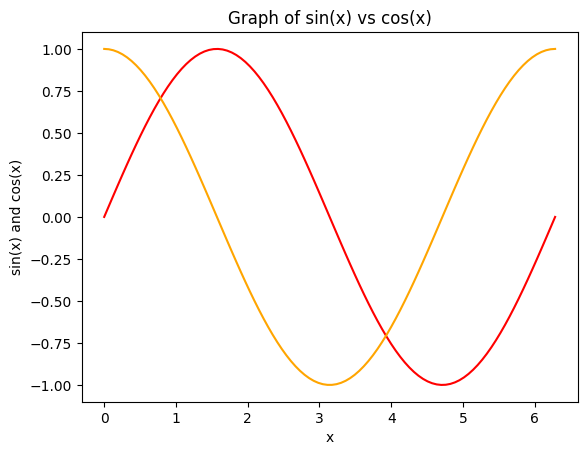

In [23]:
import matplotlib.pyplot as plt
import numpy as np

num = np.linspace(0, 2*np.pi, 100)
phase_diff = 0

x = np.sin(num)
y = np.cos(num + phase_diff)


plt.plot(num, x, label="sin wave", color="red")
plt.plot(num, y, label="cos wave", color="orange")

plt.xlabel("x")
plt.ylabel("sin(x) and cos(x)")
plt.title("Graph of sin(x) vs cos(x)")
plt.show()

## Why use sine and cos function for the positional embedding
`sin(A + B) = sin(A).cos(B) + cos(A).sin(B)`
`cos(A + B) = cos(A).cos(B) - sin(A).sin(B)` 

Since our model will have both sin and cosine avalible at the same frequency K // 2
Maybe our model can say that word A might be 3 seats away from word B in a very high dimensional space. <br />
So we can think of sine and cosine as a way to navigate in a very high dimensional space. <br />
These embedding are not learned like in the original paper. <br/>
Why use this sin cos, instead of assigning then random ID's the thing is that neural net get's really sensetive with numbers.

In [28]:
import math
import string
from src.tokenizer import Tokenizer

tokenizer = Tokenizer(string.printable)
input = tokenizer.encode("Hello")

def positional(pos, d):
    result = [0] * d
    
    for k in range(0, d):
        i = k // 2 

        denom = math.pow(1000, 2 * i / d)

        if k % 2 == 0:
            result[k] = math.sin(pos / denom) # as we move forward, the function slows down.
        else:
            result[k] = math.cos(pos / denom)
    
    return result

d = 4
for i in range(0, len(input)):
    emb = positional(i, d)
    print(f"character={tokenizer.decoder([input[i]])} embedding={emb}")

character=H embedding=[0.0, 1.0, 0.0, 1.0]
character=e embedding=[0.8414709848078965, 0.5403023058681398, 0.03161750640243371, 0.9995000416652778]
character=l embedding=[0.9092974268256817, -0.4161468365471424, 0.06320339793316936, 0.9980006665777841]
character=l embedding=[0.1411200080598672, -0.9899924966004454, 0.09472609133274612, 0.9955033739876628]
character=o embedding=[-0.7568024953079282, -0.6536436208636119, 0.12615406653456793, 0.9920106609794029]


## Learned positional embeddings
In the original paper they used the term `positional encoding` for those fix positions.

For positionaling of the input sequence we let the model learn and decide the position.

<br/>

So why make the model "learn" a position vector from scratch using random numbers?

The model isn't learning that `hello` is at position 0. It is learning what the first seat should look like so the rest of the brain `Attention` layer can work perfectly.  <br /> <br />
Very confusing topic. Let's take an example <br /> <br />


Random/Learned: Treats the sequence like a set of specialized roles. It realizes Position 0 is the "Leader," Position 1 is the "Sub-Leader," and the Last Position is the "Final Result."

'Basically shoot it foot, by making it learn the thing we already know' <br />
The model isn't learning where position is it's learning where it's strategic value is. <br /> <br />
So it's not just positions that it is strong, it's the strategic values.
        - The model can learn that certain positions are more important for certain tasks

Example for sentiment analysis:
- Positions 0-10 (beginning): Might encode "review starts"
- Last few positions: Might encode "concluding sentiment"
- Position of [CLS] token: Crucial for classification output


Unlike sin/cos which treats all positions equally, the model learns that some positions are more "important" than others.

For syntax parsing:
- Positions -1, +1: Might mean "adjacent word"
- Positions -3 to +3: Might mean "within phrase"

For document classification:
- Entire document: Might be treated as "close enough to matter"

The model learns to use position to guide attention:
Attention head might learn:
- "Attend strongly to position 0 for classification"
- "For pronouns, attend to positions 2-5 words back"
- "For verbs, attend to immediately following position"


## Token embeddings
It is a list of vectors that captures semmantic meaning of a word. Let's say computer does not understands the word `Apple` we map it in high dimensional space where word which have similar meaning and physically closer together. <br />

Why do we need both? well positional embedding keeps track of position of input sequence and token embeddings captures the semmantic meaning of a word. If we only have token embedding the model will know apple is a fruit but wouldn't know if apple is first word, last word of a sentence.

In [ ]:
import torch.nn as nn


class Transformer(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block_size = 25
        self.d_model = 128
        self.vocab_size = 75

        self.p_e = nn.Embedding(self.block_size, self.d_model)
        self.t_e = nn.Embedding(self.vocab_size, self.d_model)

transformer = Transformer()
print(transformer.p_e)
print(transformer.t_e)

Embedding(25, 128)
Embedding(75, 128)
